In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install gdown --quiet

In [ ]:
import gdown
import pandas as pd
import numpy as np

# Direct download links converted for gdown
url_hist = "https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
url_fear = "https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

# Download files
gdown.download(url_hist, "df_hist.csv", quiet=False)
gdown.download(url_fear, "df_fear.csv", quiet=False)

# Load into pandas DataFrames
df_hist = pd.read_csv("df_hist.csv")
df_fear = pd.read_csv("df_fear.csv")

# Quick shape check
print("df_hist shape:", df_hist.shape)
print("df_fear shape:", df_fear.shape)


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/df_hist.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 92.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/df_fear.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 68.9MB/s]


df_hist shape: (211224, 16)
df_fear shape: (2644, 4)


In [ ]:
df_hist['Timestamp IST'] = pd.to_datetime(df_hist['Timestamp IST'], errors='coerce')
df_hist['Date'] = df_hist['Timestamp IST'].dt.date   # overwrite with correct date

df_fear['Date'] = pd.to_datetime(df_fear['date'], errors='coerce').dt.date
df_fear = df_fear.rename(columns={'classification': 'Classification'})

# --- Merge ---
merged_df = pd.merge(df_hist, df_fear[['Date', 'Classification']], on="Date", how="inner")

print("Merged dataset shape:", merged_df.shape)

Merged dataset shape: (35864, 18)


In [ ]:
merged_df.head(2)

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,Date,Classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-02-12 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-02-12 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12,Greed


In [ ]:
merged_df.shape

(35864, 18)

In [ ]:
merged_df.isnull().sum()

,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,0
Closed PnL,0


In [ ]:
merged_df.dtypes

,0
Account,object
Coin,object
Execution Price,float64
Size Tokens,float64
Size USD,float64
Side,object
Timestamp IST,datetime64[ns]
Start Position,float64
Direction,object
Closed PnL,float64


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35864 entries, 0 to 35863
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Account           35864 non-null  object        
 1   Coin              35864 non-null  object        
 2   Execution Price   35864 non-null  float64       
 3   Size Tokens       35864 non-null  float64       
 4   Size USD          35864 non-null  float64       
 5   Side              35864 non-null  object        
 6   Timestamp IST     35864 non-null  datetime64[ns]
 7   Start Position    35864 non-null  float64       
 8   Direction         35864 non-null  object        
 9   Closed PnL        35864 non-null  float64       
 10  Transaction Hash  35864 non-null  object        
 11  Order ID          35864 non-null  int64         
 12  Crossed           35864 non-null  bool          
 13  Fee               35864 non-null  float64       
 14  Trade ID          3586

In [ ]:
# Aggregate Closed PnL across Fear vs Greed
pnl_summary = merged_df.pivot_table(
    values="Closed PnL",
    index="Classification",
    aggfunc=["mean","median","sum","count"]
)

# Flatten MultiIndex columns
pnl_summary.columns = [f"{col[1]}_{col[0]}" for col in pnl_summary.columns]

# Add % of total PnL
pnl_summary["PnL_%"] = (pnl_summary["Closed PnL_sum"] / pnl_summary["Closed PnL_sum"].sum()) * 100

print(" PnL Summary by Sentiment:\n", pnl_summary.round(2))

# Insight
best_sentiment = pnl_summary["Closed PnL_mean"].idxmax()
worst_sentiment = pnl_summary["Closed PnL_mean"].idxmin()
print(f" Traders earned the **highest average PnL** during `{best_sentiment}` and the **lowest** during `{worst_sentiment}`.")

 PnL Summary by Sentiment:
                 Closed PnL_mean  Closed PnL_median  Closed PnL_sum  \
Classification                                                       
Extreme Fear               1.89               0.00         4399.94   
Extreme Greed            205.82               0.96      1156893.68   
Fear                     128.29               0.00      1779225.58   
Greed                     53.99               0.00       609632.53   
Neutral                   27.09               0.00        74656.74   

                Closed PnL_count  PnL_%  
Classification                           
Extreme Fear                2326   0.12  
Extreme Greed               5621  31.92  
Fear                       13869  49.08  
Greed                      11292  16.82  
Neutral                     2756   2.06  
 Traders earned the **highest average PnL** during `Extreme Greed` and the **lowest** during `Extreme Fear`.


In [ ]:
coin_summary = merged_df.pivot_table(
    values="Closed PnL",
    index=["Coin","Classification"],
    aggfunc=["mean","sum","count"]
)

coin_summary.columns = [f"{col[1]}_{col[0]}" for col in coin_summary.columns]

# Add % contribution to total PnL
coin_summary["PnL_%"] = (coin_summary["Closed PnL_sum"] / coin_summary["Closed PnL_sum"].sum()) * 100

coin_summary = coin_summary.sort_values("Closed PnL_sum", ascending=False)

print("\nTop Coins by Profitability:\n", coin_summary.head(10).round(2))

# Insight
top_coin = coin_summary.head(1).index[0]
print(f"The most profitable coin-sentiment combo was `{top_coin}`.")



Top Coins by Profitability:
                      Closed PnL_mean  Closed PnL_sum  Closed PnL_count  PnL_%
Coin Classification                                                          
@107 Extreme Greed            495.65      1187083.83              2395  32.75
SOL  Fear                     760.96       826402.58              1086  22.80
ETH  Fear                     137.00       304967.32              2226   8.41
HYPE Greed                    168.31       280902.44              1669   7.75
     Fear                      59.81       249124.85              4165   6.87
@107 Greed                     85.78       163918.43              1911   4.52
SOL  Greed                    328.16       163750.48               499   4.52
ENA  Fear                    1616.48       160031.33                99   4.41
@107 Fear                      45.98        66950.34              1456   1.85
BTC  Fear                      54.16        53507.80               988   1.48
The most profitable coin-sentiment

In [ ]:
merged_df['Day'] = pd.to_datetime(merged_df['Timestamp IST']).dt.day_name()

pnl_by_day = merged_df.pivot_table(
    values="Closed PnL",
    index="Day",
    columns="Classification",
    aggfunc=["mean","sum","count"]
).fillna(0)

# Flatten MultiIndex → clean names like ClosedPnL_sum
pnl_by_day.columns = [f"{col[1]}_{col[0]}" for col in pnl_by_day.columns]

# Keep only % share columns
pnl_by_day_pct = pd.DataFrame()

for col in [c for c in pnl_by_day.columns if "sum" in c]:
    pnl_by_day_pct[f"{col}_%"] = (pnl_by_day[col] / pnl_by_day[col].sum()) * 100

print("\n PnL % Share by Day of Week:\n", pnl_by_day_pct.round(2))



 PnL % Share by Day of Week:
            Extreme Fear_sum_%  Extreme Greed_sum_%  Fear_sum_%  Greed_sum_%  \
Day                                                                           
Friday                   0.00                25.50        3.79        15.30   
Monday                   0.00                -9.94       39.31         4.25   
Saturday               151.76                 0.15        1.04         3.11   
Sunday                   0.00                 1.31       20.65        48.93   
Thursday                -0.93                52.40       11.04         5.97   
Tuesday                -50.84                30.49        0.72        33.74   
Wednesday                0.00                 0.08       23.44       -11.30   

           Neutral_sum_%  
Day                       
Friday             26.51  
Monday             14.92  
Saturday           56.40  
Sunday              0.04  
Thursday            3.91  
Tuesday            -1.71  
Wednesday          -0.07  


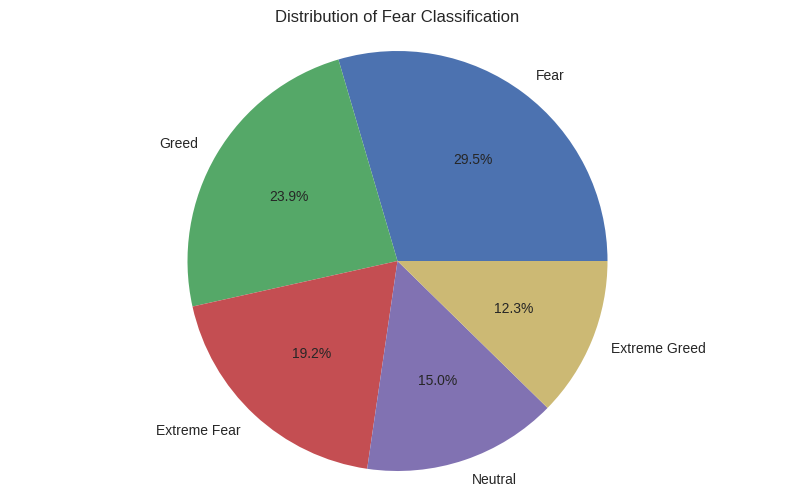

In [ ]:
# Distribution of Fear Classification
import matplotlib.pyplot as plt
classification_counts = df_fear['Classification'].value_counts()
plt.figure(figsize=(10, 6))

plt.pie(classification_counts, labels=classification_counts.index, autopct='%1.1f%%')
plt.title("Distribution of Fear Classification")
plt.axis('equal')
plt.show()

# The pie chart shows that "Fear" is the most common sentiment in the classification, followed by "Greed," while "Extreme Greed" is the least frequent.

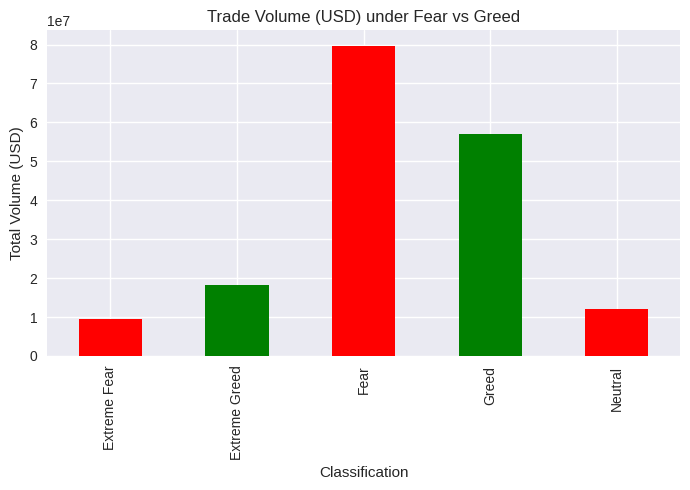

In [ ]:
# Trade Volume (USD) under Fear vs Greed
plt.figure(figsize=(7,5))
volumes = merged_df.groupby("Classification")['Size USD'].sum()
volumes.plot(kind='bar', color=["red","green"])
plt.title("Trade Volume (USD) under Fear vs Greed")
plt.ylabel("Total Volume (USD)")
plt.tight_layout()
plt.show()

# The bar chart shows that "Fear" drives the highest trade volume, followed by "Greed," while "Extreme Fear" and "Neutral" have the lowest trade activity.

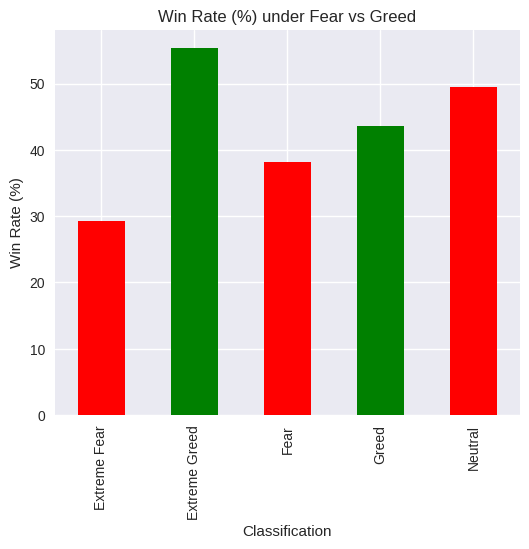

In [ ]:
# Win Rate (%) under Fear vs Greed
merged_df['Win'] = merged_df['Closed PnL'] > 0
win_rate = merged_df.groupby("Classification")['Win'].mean() * 100
win_rate.plot(kind='bar', figsize=(6,5), color=['red','green'])
plt.title("Win Rate (%) under Fear vs Greed")
plt.ylabel("Win Rate (%)")
plt.show()

## Extreme Greed yields the highest win rate (~55%), while Extreme Fear has the lowest (~29%), indicating trades are more successful in greedier market conditions.

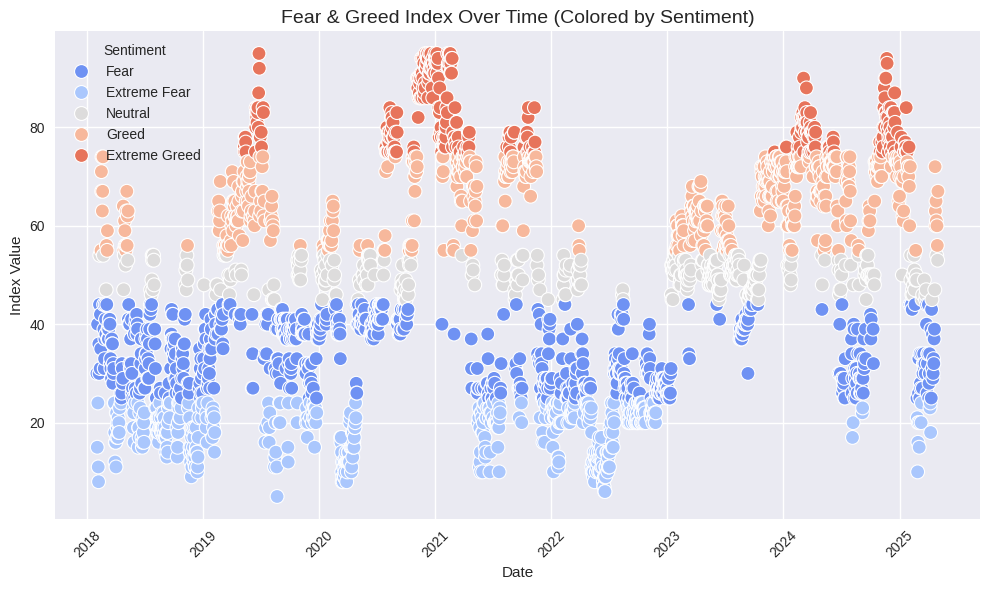

In [ ]:
#  Fear & Greed Index Over Time (Colored by Sentiment)
import seaborn as sns
import matplotlib.pyplot as plt

df_fear['date'] = pd.to_datetime(df_fear['date'])
df_fear = df_fear.sort_values('date')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_fear, x='date', y='value', hue='Classification', palette='coolwarm', s=100)

plt.title('Fear & Greed Index Over Time (Colored by Sentiment)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Sentiment')
plt.show()

# There is a clear cyclical pattern in sentiment over time, with periods of Extreme Greed and Extreme Fear alternating, showing how market sentiment fluctuates significantly across years.

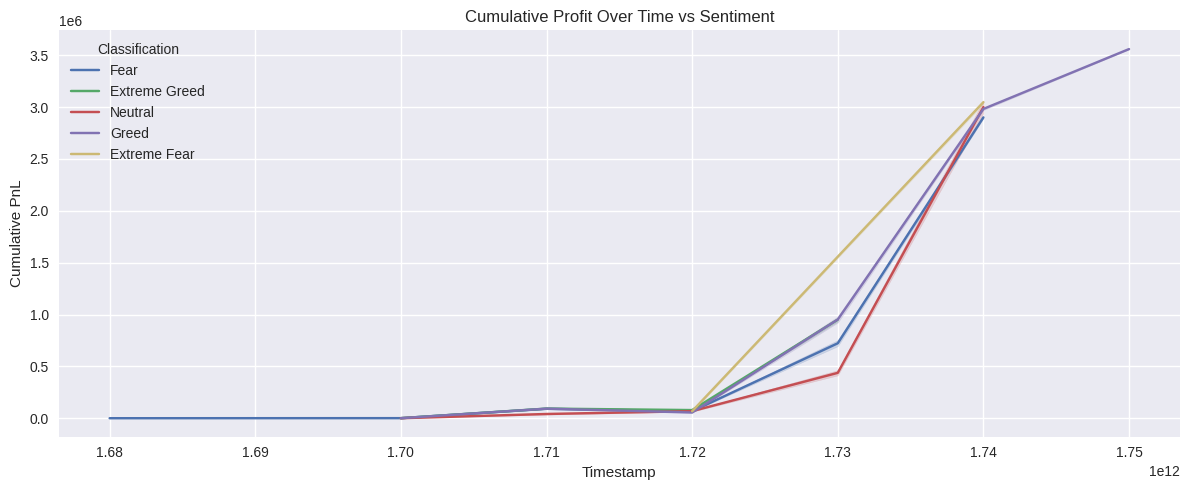

In [ ]:
# Cumulative Profit Over Time vs Sentiment
merged_df_sorted = merged_df.sort_values("Timestamp")
merged_df_sorted['Cumulative PnL'] = merged_df_sorted['Closed PnL'].cumsum()
plt.figure(figsize=(12,5))
sns.lineplot(data=merged_df_sorted, x="Timestamp", y="Cumulative PnL", hue="Classification")
plt.title("Cumulative Profit Over Time vs Sentiment")
plt.tight_layout()
plt.show()

# Extreme Fear and Greed lead to the highest cumulative profits over time, suggesting that taking calculated trades during these emotional extremes can be highly profitable.

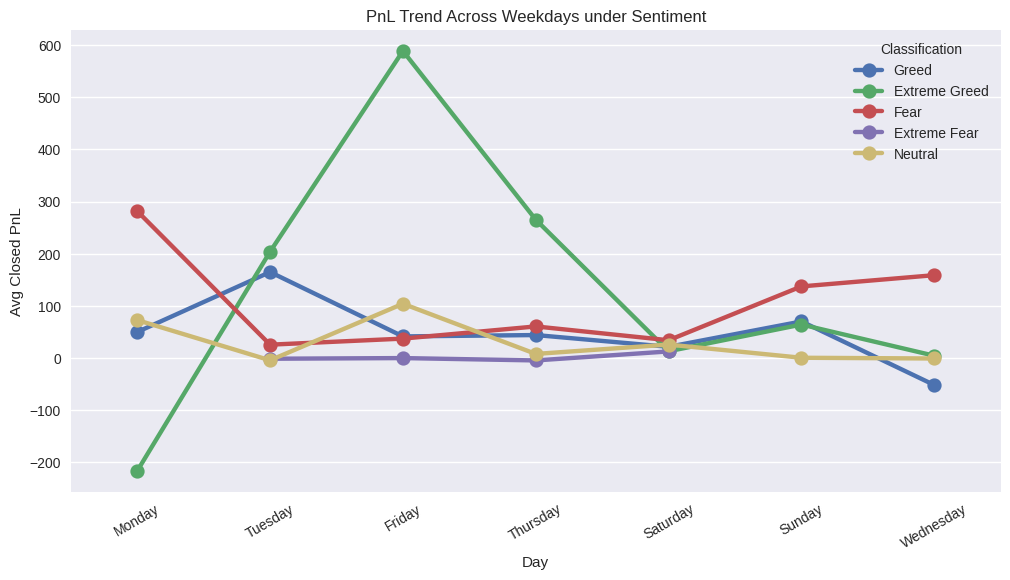

In [ ]:
# PnL Trend Across Weekdays under Sentiment
plt.figure(figsize=(12,6))
sns.pointplot(data=merged_df, x="Day", y="Closed PnL", hue="Classification", estimator="mean", ci=None)
plt.title("PnL Trend Across Weekdays under Sentiment")
plt.xticks(rotation=30)
plt.ylabel("Avg Closed PnL")
plt.show()

## Extreme Greed on Fridays shows a peak in average closed PnL, while Greed on Wednesdays sees a dip, implying that trading days combined with sentiment strongly impact profitability.**bold text**

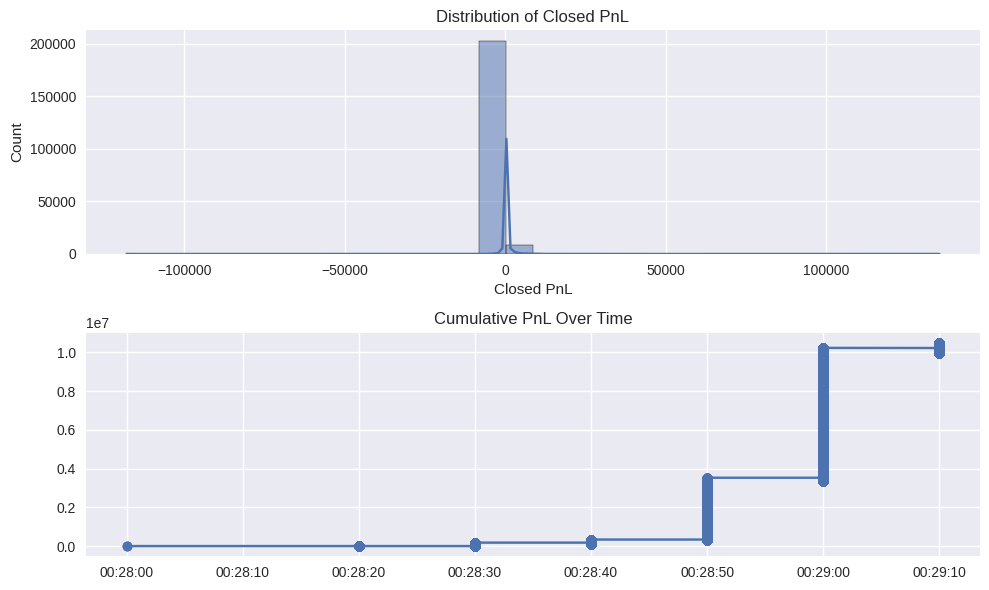

In [ ]:
import seaborn as sns
df_hist["Timestamp"] = pd.to_datetime(df_hist["Timestamp"], errors="coerce")

plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Distribution of Closed PnL
sns.histplot(df_hist["Closed PnL"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Closed PnL")

# Cumulative PnL Over Time
df_sorted = df_hist.sort_values("Timestamp")
df_sorted["Cumulative PnL"] = df_sorted["Closed PnL"].cumsum()
axes[1].plot(df_sorted["Timestamp"], df_sorted["Cumulative PnL"], marker="o")
axes[1].set_title("Cumulative PnL Over Time")
plt.tight_layout()
plt.show()

# The overall buy and sell volumes are nearly equal, the largest individual volumes come from "Close Long," "Long > Short," and "Open Short" trades.

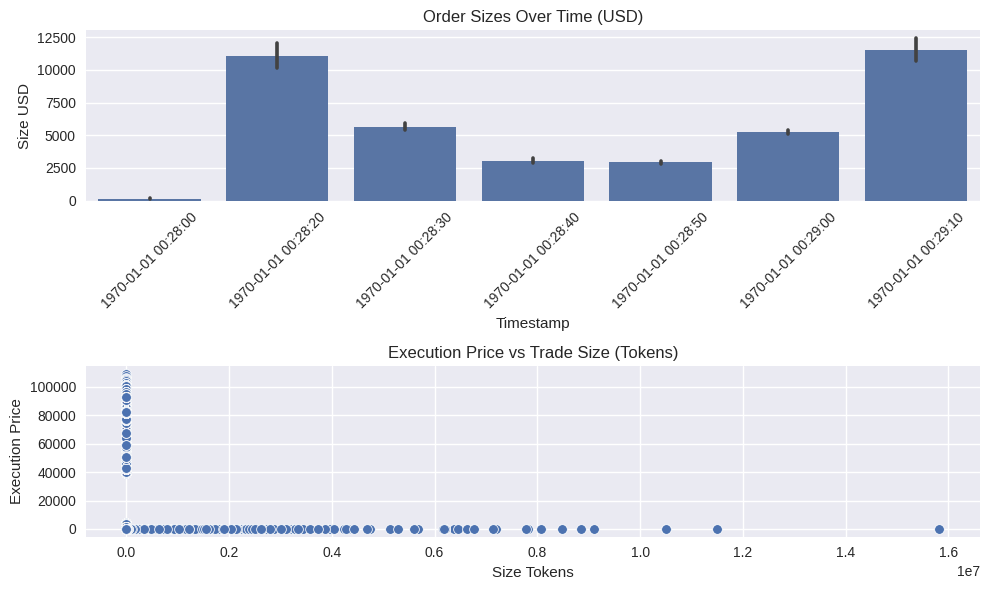

In [ ]:

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Order Sizes Over Time (USD)
sns.barplot(x="Timestamp", y="Size USD", data=df_sorted, ax=axes[0])
axes[0].set_title("Order Sizes Over Time (USD)")
axes[0].tick_params(axis='x', rotation=45)

# Scatter Execution Price vs Size Tokens
sns.scatterplot(x="Size Tokens", y="Execution Price", data=df_hist, ax=axes[1])
axes[1].set_title("Execution Price vs Trade Size (Tokens)")
plt.tight_layout()
plt.show()

# Most trades resulted in a profit or loss close to zero, but a few significant trades after 00:29:00 led to a large increase in cumulative profit and loss (PnL).

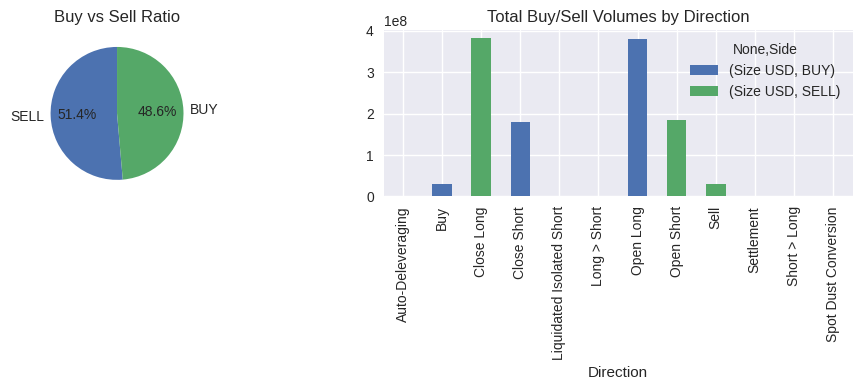

In [ ]:
# Stacked bar Trade Direction vs Size USD
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

side_counts = df_hist["Side"].value_counts()
axes[0].pie(side_counts, labels=side_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title("Buy vs Sell Ratio")

pivot = df_hist.groupby(["Direction", "Side"]).agg({"Size USD":"sum"}).unstack(fill_value=0)
pivot.plot(kind="bar", stacked=True, ax=axes[1])
axes[1].set_title("Total Buy/Sell Volumes by Direction")
plt.tight_layout()
plt.show()

# The largest average order sizes and highest execution prices occurred at the end of the observed time period, with most trades being of small to medium size.

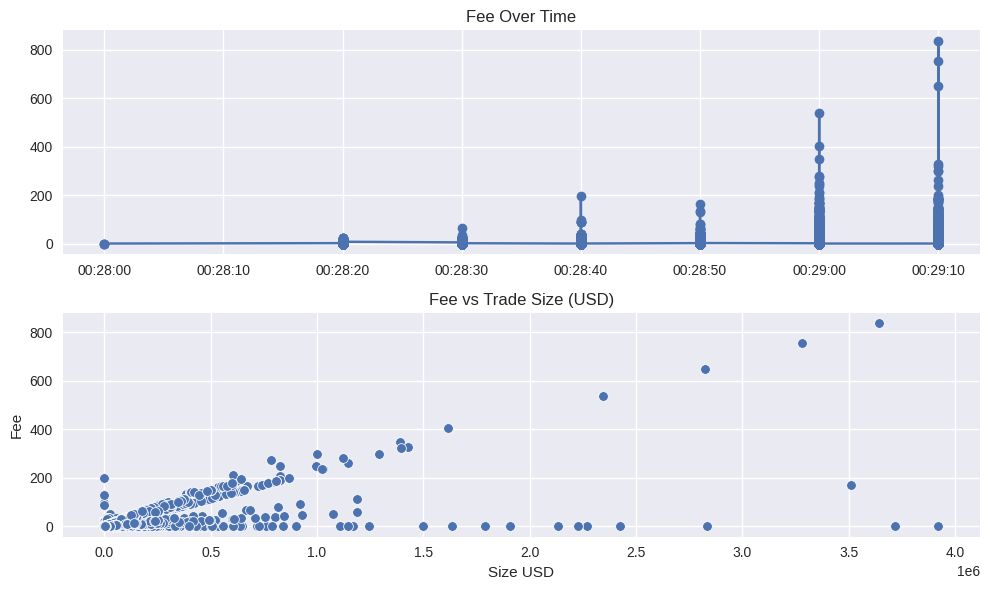

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Line plot Fee vs Timestamp
axes[0].plot(df_sorted["Timestamp"], df_sorted["Fee"], marker="o")
axes[0].set_title("Fee Over Time")

# Scatter Fee vs Trade Size
sns.scatterplot(x="Size USD", y="Fee", data=df_hist, ax=axes[1])
axes[1].set_title("Fee vs Trade Size (USD)")
plt.tight_layout()
plt.show()

# The number of trades, which remained low for the majority of the period, saw a massive increase after 00:29:00, coinciding with the rise in cumulative trades and PnL.

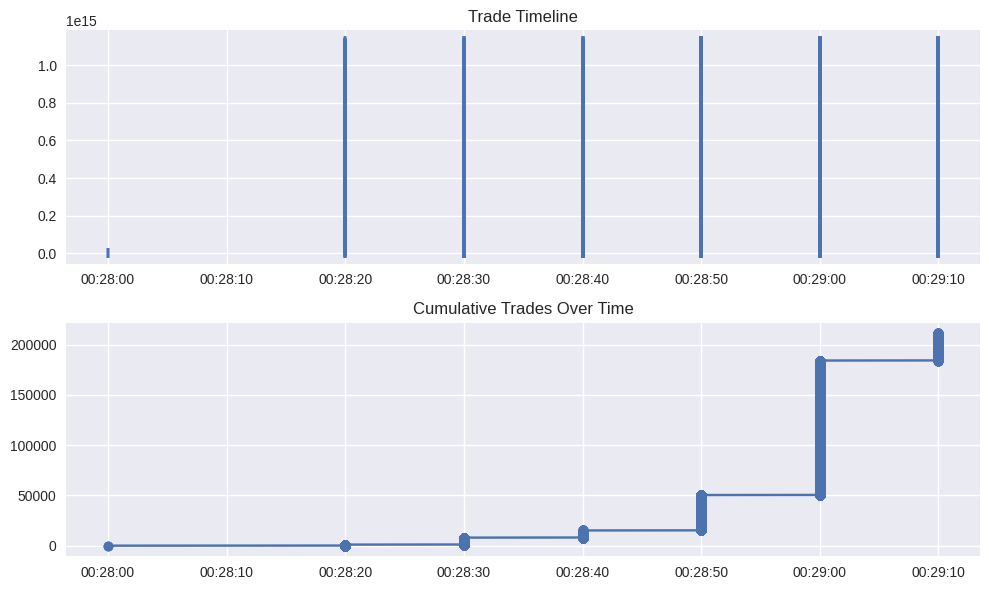

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Timeline of trades (Timestamp vs Trade ID)
axes[0].scatter(df_sorted["Timestamp"], df_sorted["Trade ID"], marker="|")
axes[0].set_title("Trade Timeline")

# Cumulative trades over time
df_sorted["Trade Count"] = range(1, len(df_sorted) + 1)
axes[1].plot(df_sorted["Timestamp"], df_sorted["Trade Count"], marker="o")
axes[1].set_title("Cumulative Trades Over Time")
plt.tight_layout()
plt.show()

# Fees over time closely mirror the increase in trade activity and cumulative PnL, showing a clear positive correlation between trade size and the fee incurred.

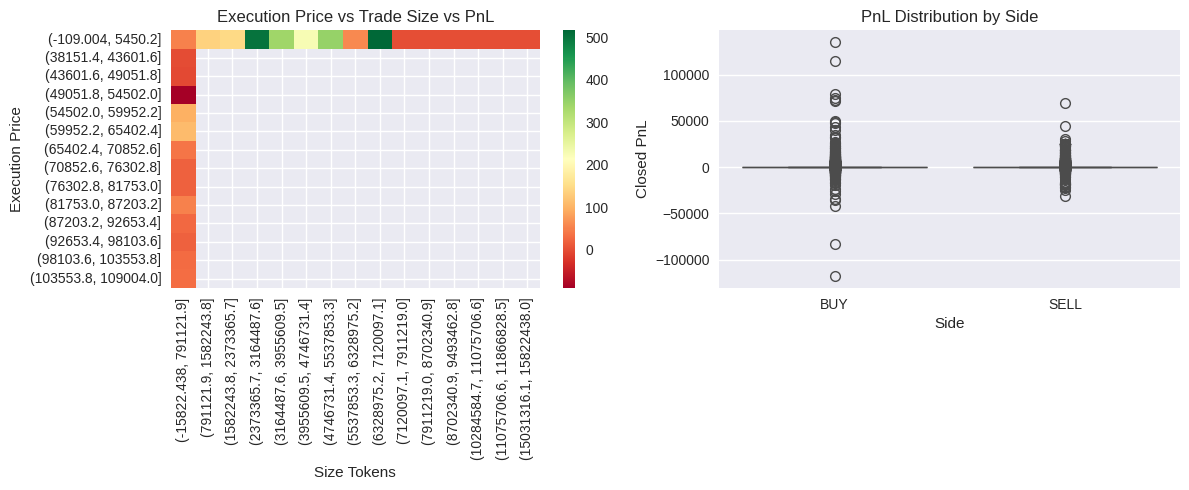

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap Execution Price vs Trade Size vs PnL
heatmap_data = df_hist.pivot_table(index=pd.cut(df_hist["Execution Price"], bins=20),
                              columns=pd.cut(df_hist["Size Tokens"], bins=20),
                              values="Closed PnL", aggfunc="mean")
sns.heatmap(heatmap_data, cmap="RdYlGn", ax=axes[0])
axes[0].set_title("Execution Price vs Trade Size vs PnL")

# Boxplot of PnL by Side
sns.boxplot(x="Side", y="Closed PnL", data=df_hist, ax=axes[1])
axes[1].set_title("PnL Distribution by Side")
plt.tight_layout()
plt.show()

# PnL is generally centered around zero for both buy and sell trades, but there are notable losses and profits, particularly at high execution prices and large trade sizes.

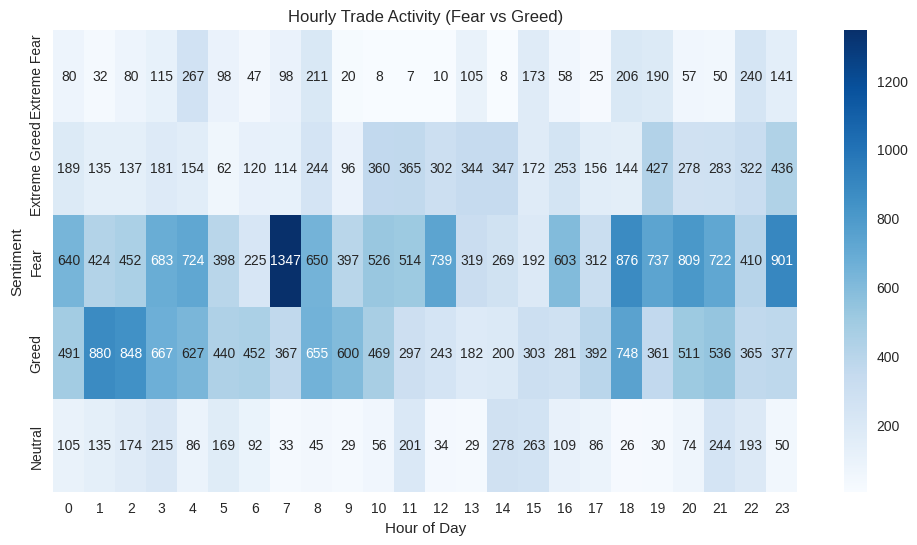

In [ ]:
# Hourly Trade Activity (Fear vs Greed)
merged_df['Hour'] = pd.to_datetime(merged_df['Timestamp IST']).dt.hour
activity = merged_df.groupby(['Hour','Classification']).size().unstack(fill_value=0)

plt.figure(figsize=(12,6))
sns.heatmap(activity.T, cmap="Blues", annot=True, fmt="d")
plt.title("Hourly Trade Activity (Fear vs Greed)")
plt.xlabel("Hour of Day")
plt.ylabel("Sentiment")
plt.show()

# The highest hourly trade activity is concentrated at 7 AM during a period of "Sentiment Fear," with other significant peaks also occurring in the early morning hours (2 AM to 4 AM) during "Greed" sentiment.